# Filtering and trimming messages

Let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [ ]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-demo"

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Robin")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Robin

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='In addition to whales, there are several other fascinating ocean mammals you might want to explore:\n\n1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are part of the family Delphinidae and are found in oceans around the world.\n\n2. **Porpoises**: Smaller and less well-known than dolphins, porpoises belong to the family Phocoenidae and have a more robust body and different facial structure.\n\n3. **Seals**: These marine mammals are part of the pinniped family and are adapted to life both in and out of the water. They are found in various climates from polar waters to tropical beaches.\n\n4. **Sea Lions**: Also part of the pinniped family, sea lions are known for their external ear flaps and ability to walk on land using their large flippers.\n\n5. **Walruses**: Recognized by their tusks and whiskers, walruses are large pinnipeds primarily found in Arctic regions.\n\n6. **Manatees**: Also known as sea cows, manatees are gentle herbivores 

We can run our chat model in a simple graph with `MessagesState`.

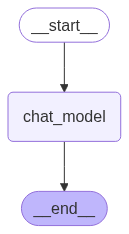

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Robin

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating groups of ocean mammals you might want to explore:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are part of the cetacean family along with whales. Common species include the bottlenose dolphin and the orca, or killer whale, which is actually the largest member of the dolphin family.

2. **Porpoises**: Similar to dolphins but generally smaller and stouter, porpoises are another group in the cetacean family. Harbor porpoises are one of the most commonly known species.

3. **Seals**: These are part of the pinniped family and include 

## Reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

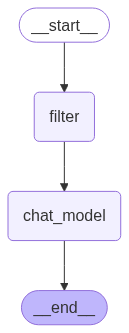

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Robin", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Robin", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Robin

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals besides whales that you might want to explore. Here are a few noteworthy ones:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and acrobatic abilities. There are several species, including the common bottlenose dolphin and the orca, which is technically a type of dolphin.

2. **Seals and Sea Lions**: These are pinnipeds, a group that also includes walruses. Seals like the harbor seal are more adapted for life in the water, whereas sea lions and fur seals, such as the Californian sea lion, are more agile on land.



## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

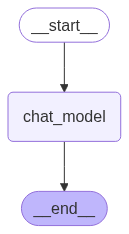

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Robin

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Robin

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals besides whales that you might want to explore. Here are a few noteworthy ones:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and acrobatic abilities. There are several species, including the common bottlenose dolphin and the orca, which is technically a type of dolphin.

2. **Seals and Sea Lions**: These are pinnipeds, 

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Robin

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Robin

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals besides whales that you might want to explore. Here are a few noteworthy ones:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and acrobatic abilities. There are several species, including the common bottlenose dolphin and the orca, which is technically a type of dolphin.

2. **Seals and Sea Lions**: These are pinnipeds, 

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

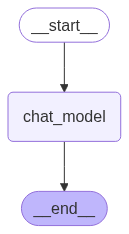

In [14]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [17]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

In [18]:
messages_out_trim

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Robin', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Robin', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  AIMessage(content='There are several fascinating ocean mammals besides whales that you might want to explore. Here are a few noteworthy ones:\n\n1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and acrobatic abilities. There are several species, including the common bottlenose dolphin and the orca, which is technically a type of dolphin.\n\n2. **Seals and Sea Lions**: These are pinnipeds, a group that also includes walruses. Seals like the har

Let's look at the LangSmith trace to see the model invocation: